In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import matthews_corrcoef
from transformers import AutoTokenizer, TFAlbertModel
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import torch
from transformers import AdamW
%matplotlib inline

c:\Users\tarik\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = pd.read_pickle('preprocessed_data.pkl')

In [4]:
data.head()

,sender,receiver,date,subject,body,label,url_count,email_type,number_count,day_of_week,...,sender_mail,body_length,subject_length,body_word_count,subject_word_count,body_char_count,subject_char_count,body_sentiment,subject_sentiment,suspicious_word_count
0,young esposito,user4@gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,never agree to be a loser,buck trouble caused small dimension soon becom...,1.0,1,0,0,Tuesday,...,young@iworld.de,167,25,24,6,144,20,0.137500,0.00,0
1,mok,user2.2@gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,befriend jenna jameson,upgrade sex pleasure technique http www bright...,1.0,1,0,0,Tuesday,...,ipline's1983@icable.ph,54,22,8,3,47,20,0.000000,0.00,0
2,daily top 10,user2.9@gvc.ceas-challenge.cc,2008-08-06 08:28:00+00:00,cnn com daily top 10,daily top cnn com top video story aug pm ...,1.0,1,0,107,Wednesday,...,karmandeep-opengevl@universalnet.psi.br,2756,20,462,5,2201,16,0.083844,0.25,0
3,michael parker,spamassassin dev <xrh@spamassassin.apache.org>,2008-08-05 23:31:20+00:00,svn commit r619753 in spamassassin trunk lib m...,would anyone object removing list tld basicall...,0.0,1,1,132,Tuesday,...,ivqrnai@pobox.com,18567,141,3581,20,14862,122,0.027670,0.00,0
4,gretchen suggs,user2.2@gvc.ceas-challenge.cc,2008-08-05 23:31:21+00:00,specialpricespharmmoreinfo,welcomefastshippingcustomersupport http iwfna ...,1.0,1,0,14,Tuesday,...,externalsep1@loanofficertool.com,154,26,11,1,144,26,0.000000,0.00,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176152 entries, 0 to 185473
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   sender                 176152 non-null  object             
 1   receiver               176152 non-null  object             
 2   date                   171574 non-null  datetime64[ns, UTC]
 3   subject                176152 non-null  object             
 4   body                   176152 non-null  object             
 5   label                  176152 non-null  float64            
 6   url_count              176152 non-null  int32              
 7   email_type             176152 non-null  int64              
 8   number_count           176152 non-null  int64              
 9   day_of_week            171574 non-null  object             
 10  month                  171574 non-null  float64            
 11  time_of_day            171574 non-null  floa

In [6]:
textual_columns = ['sender', 'receiver', 'subject', 'body']
data['combined_text'] = data[textual_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

data = data[['combined_text', 'label']] 

In [8]:
text_data=data["combined_text"]
label_data=data["label"]
label_data=np.array(label_data)

In [9]:
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [10]:
albert_model = TFAlbertModel.from_pretrained("albert-base-v2")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [11]:
def albert_encode(final_text, my_maxlen):
    input_ids = []
    attention_masks = []
    
    print(f"Encoding {len(final_text)} entries...")
    for i in range(len(final_text)):
        try:
            encode_data = albert_tokenizer.encode_plus(final_text[i], add_special_tokens=True, max_length=my_maxlen, pad_to_max_length=True, return_attention_mask=True)
            input_ids.append(encode_data['input_ids'])
            attention_masks.append(encode_data["attention_mask"])
        except KeyError as e:
            print(f"Error encoding index {i}: {e}")

    return np.array(input_ids), np.array(attention_masks)


In [12]:
maxlen = 256

In [13]:
text_data = data["combined_text"].reset_index(drop=True)
text_input_ids, text_attention_masks = albert_encode(text_data, maxlen)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Encoding 176152 entries...


c:\Users\tarik\miniconda3\lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
X_train_input,X_test_input,Y_train_label,Y_test_label,train_mask,test_mask=train_test_split(text_input_ids,label_data,text_attention_masks,test_size=0.2,random_state=42,shuffle=True)

In [15]:
def Create_Albert_Model():
    
    input_ids = tf.keras.Input(shape=(maxlen,), dtype="int32")
    attention_masks = tf.keras.Input(shape=(maxlen,), dtype="int32")
    output_dim = albert_model([input_ids,attention_masks])[1]
    dense_1 = tf.keras.layers.Dense(128, activation="tanh")(output_dim)
    dense_2 = tf.keras.layers.Dense(64, activation="relu")(dense_1)
    dropout = tf.keras.layers.Dropout(0.2)(dense_2)
    
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
    
    return model

In [18]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
model = Create_Albert_Model()

model.compile(loss="binary_crossentropy", optimizer=AdamW(learning_rate=6e-6), metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  11683584   ['input_1[0][0]',                
 )                              thPooling(last_hidd               'input_2[0][0]']                
                                en_state=(None, 256                                               
                                , 768),                                                       

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    x=[X_train_input, train_mask],
    y=Y_train_label,
    validation_data=([X_test_input, test_mask], Y_test_label),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
4404/4404 [==============================] - 1432s 325ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.0213 - val_accuracy: 0.9929
Epoch 2/10
4404/4404 [==============================] - 1431s 325ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0189 - val_accuracy: 0.9941
Epoch 3/10
4404/4404 [==============================] - 1441s 327ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0206 - val_accuracy: 0.9935
Epoch 4/10
4404/4404 [==============================] - 1442s 328ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0319 - val_accuracy: 0.9878
Epoch 5/10
4404/4404 [==============================] - 1433s 325ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0195 - val_accuracy: 0.9940
Epoch 5: early stopping


In [ ]:
fig, ax= plt.subplots(ncols=2, figsize=(15,6))

# Plot for accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
ax[0].plot(epochs, loss_train, color="magenta", marker="*", lw=2, linestyle="--", label='Training Accuracy')
ax[0].plot(epochs, loss_val, color="darkorange", marker="D", lw=2, linestyle="-.", label='Validation Accuracy')
ax[0].set_title('Accuracy', fontsize=15, color="azure")
ax[0].set_xlabel('Epochs', fontsize=15, color="azure")
ax[0].set_ylabel('Accuracy', fontsize=15, color="azure")
ax[0].legend(fontsize=12)

# Plot for loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
ax[1].plot(epochs, loss_train, color="navy", marker="*", lw=2, linestyle="--", label='Training Loss')
ax[1].plot(epochs, loss_val, color="lime", marker="D", lw=2, linestyle="-.", label='Validation Loss')
ax[1].set_title('Loss', fontsize=15, color="snow")
ax[1].set_xlabel('Epochs', fontsize=15, color="snow")
ax[1].set_ylabel('Loss', fontsize=15, color="snow")
ax[1].legend(fontsize=12)
plt.show()

In [23]:
pred = model.predict([X_test_input, test_mask])
final_pred = np.where(pred >= 0.5, 1, 0)

1101/1101 [==============================] - 135s 120ms/step


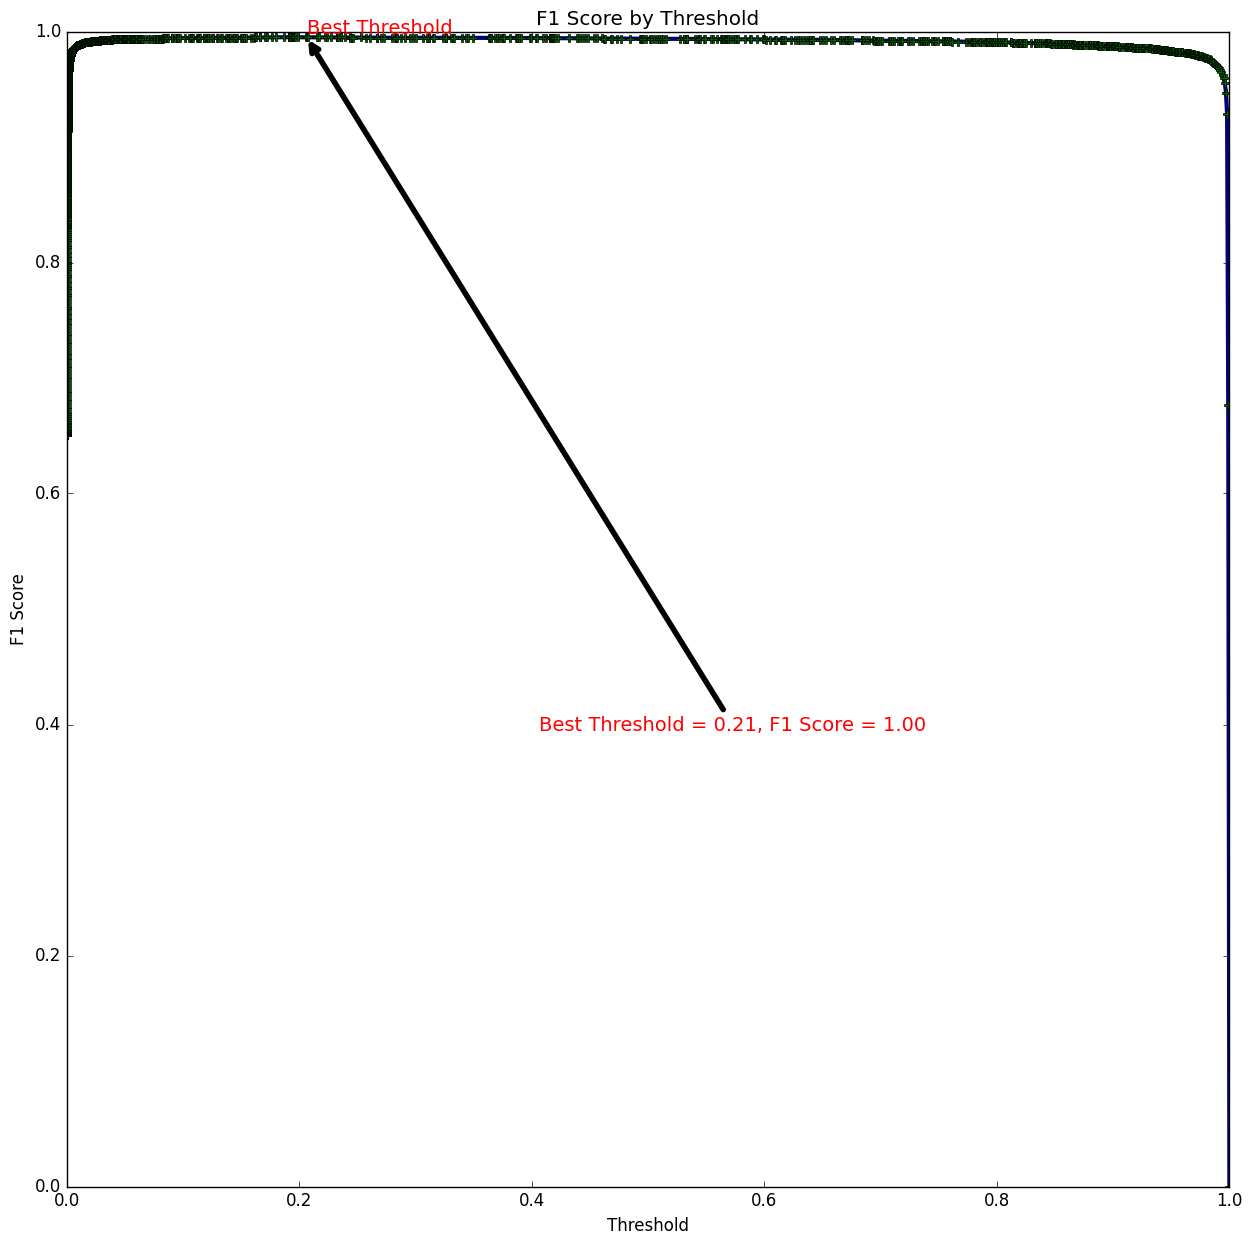

In [24]:
plt.figure(figsize=(15,15))
plt.style.use("classic")
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test_label,pred)

# calculate F1 score for each threshold
f1_scores = [f1_score(Y_test_label,pred > t) for t in thresholds]

# plot F1 score vs threshold
plt.plot(thresholds, f1_scores,marker="P",lw=3,markersize=6,color="navy",markerfacecolor='darkgreen')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold')
# find index of highest F1 score
best_f1_index = np.argmax(f1_scores)

# get corresponding threshold value
best_threshold = thresholds[best_f1_index]

# plot text at the best point
plt.text(best_threshold, f1_scores[best_f1_index], "Best Threshold",ha="left",va="bottom", color='red', fontsize=14)
# add arrow pointing to the best point
arrow_x = best_threshold
arrow_y = f1_scores[best_f1_index]
arrow_text = f"Best Threshold = {best_threshold:.2f}, F1 Score = {arrow_y:.2f}"

plt.annotate(arrow_text, xy=(arrow_x, arrow_y), xytext=(arrow_x+0.2, arrow_y -0.6),
             arrowprops=dict(facecolor='brown', arrowstyle="->",lw=4), color='red', fontsize=14)


plt.show()

In [30]:
import pickle

with open('albert_model.pkl', 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://1799e410-90ce-420b-a6df-8d7e2623d6d2/assets


INFO:tensorflow:Assets written to: ram://1799e410-90ce-420b-a6df-8d7e2623d6d2/assets


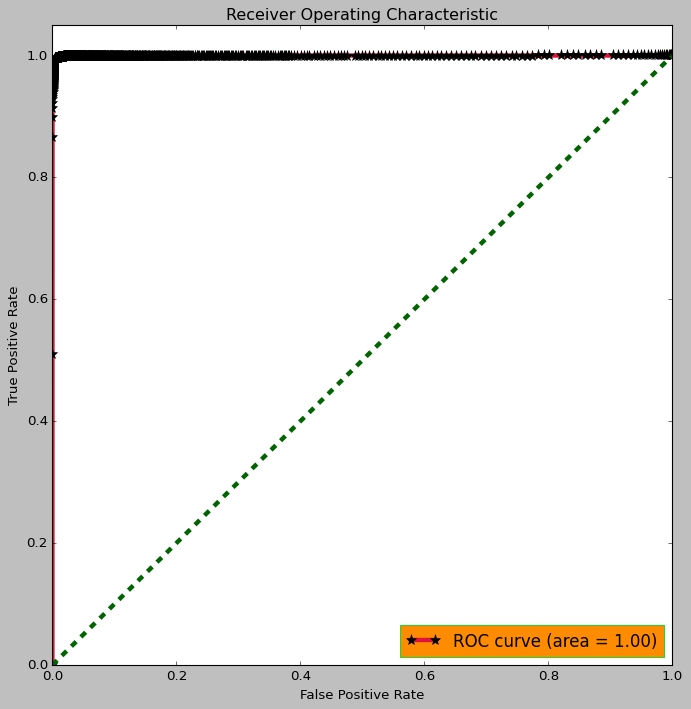

In [25]:
fpr, tpr, thresholds = roc_curve(Y_test_label,pred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(10,10))
plt.style.use("classic")
plt.plot(fpr, tpr,marker="*",markersize=10,markerfacecolor="black",color='crimson', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgreen', lw=4, linestyle='--',markersize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right",fontsize=15,edgecolor='limegreen', facecolor='darkorange')
plt.show()

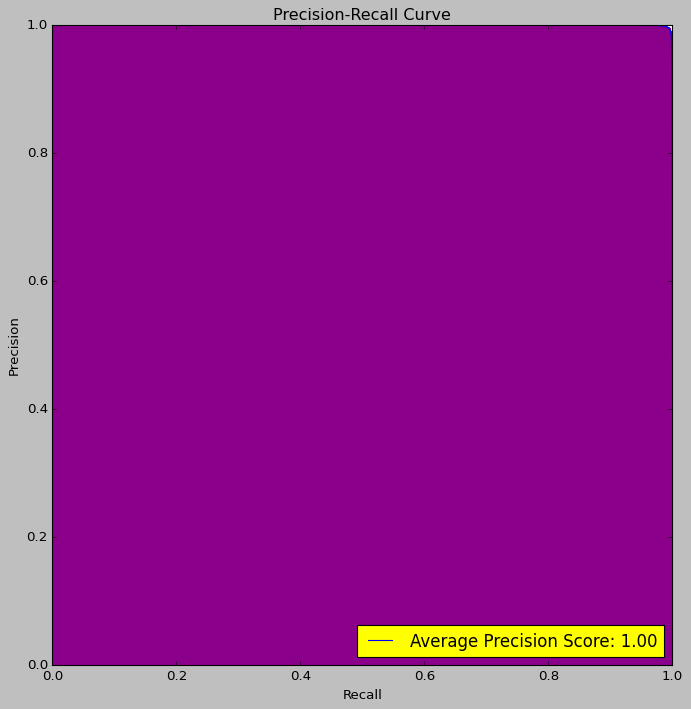

In [26]:
plt.figure(figsize=(10,10))
plt.style.use("classic")
precision, recall, thresholds = precision_recall_curve(Y_test_label, pred)
score = average_precision_score(Y_test_label, pred)
plt.step(recall, precision, color='b', where='post', label='Average Precision Score: {:.2f}'.format(score))
plt.fill_between(recall, precision, step='post',color="darkmagenta")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right", fontsize=15,facecolor="yellow")
plt.show()

In [27]:
roc_auc = roc_auc_score(Y_test_label, pred)
print('ROC AUC=%.3f' % (roc_auc))

kappa = cohen_kappa_score(Y_test_label,final_pred)
print('Cohens kappa: %f' % kappa)

mcc = matthews_corrcoef(Y_test_label, final_pred)
print('MCC: %f' % mcc)

log_loss = log_loss(Y_test_label, pred)
print('Log Loss: %f' % log_loss)

brier_score = brier_score_loss(Y_test_label, pred)
print('Brier Score: %f' % brier_score)


ROC AUC=1.000
Cohens kappa: 0.988117
MCC: 0.988137
Log Loss: 0.019233
Brier Score: 0.004635


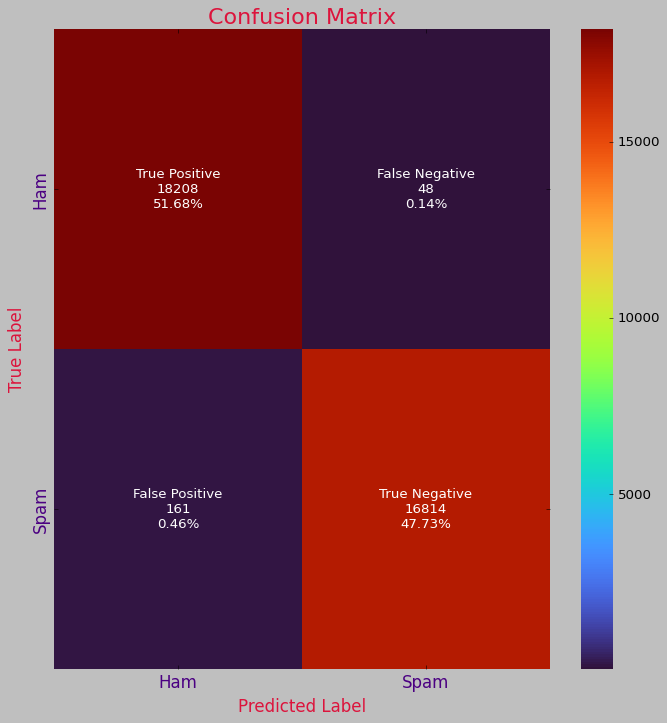

In [28]:
my_label_data=["Ham","Spam"]
my_matrix= confusion_matrix(Y_test_label, final_pred)
my_label = ["True Positive","False Negative","False Positive","True Negative"]
my_label_count=["{0:0.0f}".format(value) for value in my_matrix.flatten()]
percentage=["{0:.2%}".format(value) for value in my_matrix.flatten()/np.sum(my_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(my_label,my_label_count,percentage)]
labels=np.asarray(labels).reshape(2, 2)
# Plot confusion matrix as heatmap using Seaborn
plt.figure(figsize=(10,10))
sns.heatmap(my_matrix, annot=labels, cmap="turbo", fmt="", cbar=True,
            xticklabels=my_label_data,yticklabels=my_label_data)
plt.xlabel("Predicted Label",fontsize=15,color="crimson")
plt.ylabel("True Label",fontsize=15,color="crimson")
plt.title("Confusion Matrix",fontsize=20,color="crimson")
plt.xticks(fontsize=15,color="indigo")
plt.yticks(fontsize=15,color="indigo")
plt.show()

In [29]:
print(classification_report(Y_test_label,final_pred,target_names=my_label_data))

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99     18256
        Spam       1.00      0.99      0.99     16975

    accuracy                           0.99     35231
   macro avg       0.99      0.99      0.99     35231
weighted avg       0.99      0.99      0.99     35231



In [32]:
model.save('albert_model_weights.h5')

In [38]:
loaded_model = tf.keras.models.load_model('albert_model_weights.h5', custom_objects={"TFAlbertModel": TFAlbertModel.from_pretrained("albert-base-v2")})
loaded_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_albert_model_5 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_1[0][0]',                
 el)                            thPooling(last_hidd               'input_2[0][0]']                
                                en_state=(None, 256                                               
                                , 768),                                                       

In [7]:
loaded_model = tf.keras.models.load_model('albert_model_weights.h5', custom_objects={"TFAlbertModel": TFAlbertModel.from_pretrained("albert-base-v2")})
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# predict some random sentence

text = "Hi, I am a Nigerian prince, and I want to give you a million dollars. Please send me your bank account details."
text = albert_tokenizer.encode_plus(text, add_special_tokens=True, max_length=256, pad_to_max_length=True, return_attention_mask=True)
text_input_ids = np.array([text['input_ids']])
text_attention_masks = np.array([text['attention_mask']])
pred = loaded_model.predict([text_input_ids, text_attention_masks])
pred

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` 

1/1 [==============================] - 1s 1s/step


array([[0.998]], dtype=float16)